Get dataset

In [ ]:
! unzip '/content/humanitarian_5classes.zip' 

unzip:  cannot find or open /content/humanitarian_5classes.zip, /content/humanitarian_5classes.zip.zip or /content/humanitarian_5classes.zip.ZIP.


In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('humanitarian_SMALL_5classes.tsv', sep='\t')
df_train = df[df.split=='TRAIN']
df_dev = df[df.split=='DEV']
df_test = df[df.split=='TEST']

Preprocess/clean data

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
import re 

def clean_tweet(tweet):
    temp = tweet.lower()
    temp = re.sub("'", "", temp)  
    temp = re.sub('[()!?]', ' ', temp)
    temp = re.sub('\[.*?\]',' ', temp)
    temp = re.sub("@[A-Za-z0-9_]+","<MENTION>", temp)
    temp = re.sub("#[A-Za-z0-9_]+","<HASHTAG>", temp)
    temp = re.sub(r'http\S+', "<LINK>", temp)
    temp = temp.replace("\brt\b","<RETWEET>").strip()
    temp = re.sub("@[A-Za-z0-9_]+","", temp)
    temp = re.sub(r'http\S+', "", temp)
    temp = re.sub(r'\brt\b',"", temp).strip()
    temp = re.sub("[^a-zA-Z0-9<>]", " ", temp)
    temp = re.sub(' +', ' ', temp) #remove extra whitespace

    return temp

In [ ]:
dev=df_dev.copy()
train=df_train.copy()
test=df_test.copy()

In [ ]:
len_ls = list([len(dev), len(test), len(train)])
print(len_ls, "\nTotal :", sum(len_ls))

[998, 955, 6126] 
Total : 8079


In [ ]:
dev['tweet_text'] = dev['tweet_text'].apply(lambda x: clean_tweet(x))
train['tweet_text'] = train['tweet_text'].apply(lambda x: clean_tweet(x))
test['tweet_text'] = test['tweet_text'].apply(lambda x: clean_tweet(x))

In [ ]:
# task_labels = train['label_text'].unique()
task_labels = ['infrastructure_and_utility_damage', 'other_relevant_information', 'not_humanitarian', 'rescue_volunteering_or_donation_effort', 'affected_individuals']

label_dict = {}
for index, label in enumerate(task_labels):
  label_dict[label] = index

print(label_dict)

dev['label_text'] = dev['label_text'].replace(label_dict)
train['label_text'] = train['label_text'].replace(label_dict)
test['label_text'] = test['label_text'].replace(label_dict)

{'infrastructure_and_utility_damage': 0, 'other_relevant_information': 1, 'not_humanitarian': 2, 'rescue_volunteering_or_donation_effort': 3, 'affected_individuals': 4}


Finetune pretrained BERT

In [ ]:
! pip install transformers

     |████████████████████████████████| 3.1 MB 10.8 MB/s 
     |████████████████████████████████| 59 kB 6.3 MB/s 
     |████████████████████████████████| 895 kB 49.7 MB/s 
     |████████████████████████████████| 3.3 MB 37.6 MB/s 
     |████████████████████████████████| 596 kB 49.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer, BertPreTrainedModel, BertModel
from transformers.modeling_outputs import SequenceClassifierOutput

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
def encode(data_values, tokenizer, max_length):
  # data_values must be of type list
  encoded_data = tokenizer.batch_encode_plus(
    data_values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding='max_length',
    truncation=True, 
    max_length=max_length, 
    return_tensors='pt'
  )
  return encoded_data

In [ ]:
class BertClassifier(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.config = config

        self.bert = BertModel(config)
        self.dropout = torch.nn.Dropout(0.2)
        self.classifier = torch.nn.Linear(config.hidden_size, config.num_labels) #sizes are (768, 5)

        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None,
                token_type_ids=None, position_ids=None, head_mask=None, 
                inputs_embeds=None, labels=None,
                output_attentions=None, output_hidden_states=None, return_dict=None,):

        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(input_ids, attention_mask=attention_mask,
            token_type_ids=token_type_ids, position_ids=position_ids, head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions, output_hidden_states=output_hidden_states, return_dict=return_dict,
            )

        pooled_output = outputs[1] 
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
          loss_fct = torch.nn.CrossEntropyLoss()
          loss = loss_fct(logits.view(-1, self.config.num_labels), labels.view(-1))
        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [ ]:
from sklearn.metrics import f1_score
import numpy as np

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)} = {len(y_preds[y_preds==label])/len(y_true)}\n')

In [ ]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
      
        logits = outputs[1]
        loss = outputs[0]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        true_labels = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(true_labels)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [ ]:
from copy import deepcopy

def train_model(model, dataloader_train, dataloader_validation, device, name=""):

  hist_train = []
  hist_val = []
  best_model_state = None

  best_loss = None
  patience = 3
  min_diff = 0.05
  counter = 0

  for epoch in tqdm(range(1, epochs+1)):
      
      model.train()

      loss_train_total = 0

      progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
      for batch in progress_bar:

          model.zero_grad()
          
          batch = tuple(b.to(device) for b in batch)
          
          inputs = {'input_ids':      batch[0],
                    'attention_mask': batch[1],
                    'labels':         batch[2],
                  }       

          outputs = model(**inputs)
          
          loss = outputs[0]
          loss_train_total += loss.item()
          loss.backward()

          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

          optimizer.step()
          scheduler.step()
          
      # torch.save(model.state_dict(), f'/content/{name}finetuned_BERT_epoch{epoch}.model')
          
      tqdm.write(f'\nEpoch {epoch}')
      
      loss_train_avg = loss_train_total/len(dataloader_train)            
      tqdm.write(f'Training loss: {loss_train_avg}')
      
      val_loss, predictions, true_vals = evaluate(dataloader_validation)
      val_f1 = f1_score_func(predictions, true_vals)
      tqdm.write(f'Validation loss: {val_loss}')
      tqdm.write(f'F1 Score (Weighted): {val_f1}')

      hist_train.append(loss_train_avg)
      hist_val.append(val_loss)

      # early stopping with patience
      if best_loss == None:
        best_loss = val_loss
        best_model_state = deepcopy(model.state_dict())
      elif best_loss - val_loss > min_diff:
        best_loss = val_loss
        best_model_state = deepcopy(model.state_dict())
        counter = 0
      elif best_loss - val_loss < min_diff:
        counter += 1
        tqdm.write(f"INFO: Early stopping counter {counter} of {patience}")
        if counter >= patience:
            tqdm.write('INFO: Early stopping')
            break

  torch.save(best_model_state, f'/content/{name}finetuned_BERT.model')
  return hist_train, hist_val

In [ ]:
import random

def set_seed():
  seed_val = 42
  random.seed(seed_val)
  np.random.seed(seed_val)
  torch.manual_seed(seed_val)
  torch.cuda.manual_seed_all(seed_val)

set_seed()

In [ ]:
MAX_TWEET_LEN = 35

encoded_data_train = encode(train['tweet_text'].values, tokenizer, MAX_TWEET_LEN)

encoded_data_val = encode(dev['tweet_text'].values, tokenizer, MAX_TWEET_LEN)

input_ids_train, attention_masks_train = encoded_data_train['input_ids'], encoded_data_train['attention_mask']
input_ids_val, attention_masks_val = encoded_data_val['input_ids'], encoded_data_val['attention_mask']

labels_train = torch.tensor(train['label_text'].values)
labels_val = torch.tensor(dev['label_text'].values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [ ]:
BATCH_SIZE = 64

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=BATCH_SIZE)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=BATCH_SIZE)

In [ ]:
model = BertClassifier.from_pretrained("bert-base-uncased", num_labels=len(label_dict),
                                        output_attentions=False, output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertClassifier: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertClassifier from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertClassifier from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertClassifier were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.b

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

epochs = 20

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)


scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(dataloader_train)*epochs)

loss_fct = torch.nn.CrossEntropyLoss()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

DATASET_NAME = 'SMALL_5CLS'
hist_train, hist_val = train_model(model, dataloader_train=dataloader_train, dataloader_validation=dataloader_validation, 
                             device=device, name=DATASET_NAME)

cuda


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/96 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.0496324393898249
Validation loss: 0.7034036591649055
F1 Score (Weighted): 0.7756455821650237


Epoch 2:   0%|          | 0/96 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.5924485689029098
Validation loss: 0.5669947117567062
F1 Score (Weighted): 0.7964158485855926


Epoch 3:   0%|          | 0/96 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.4450451834127307
Validation loss: 0.5730994492769241
F1 Score (Weighted): 0.7926650433077995
INFO: Early stopping counter 1 of 3


Epoch 4:   0%|          | 0/96 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.35323476620639366
Validation loss: 0.5476035885512829
F1 Score (Weighted): 0.8068268991602695
INFO: Early stopping counter 2 of 3


Epoch 5:   0%|          | 0/96 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.278467686381191
Validation loss: 0.5535443387925625
F1 Score (Weighted): 0.8175925343331977
INFO: Early stopping counter 3 of 3
INFO: Early stopping


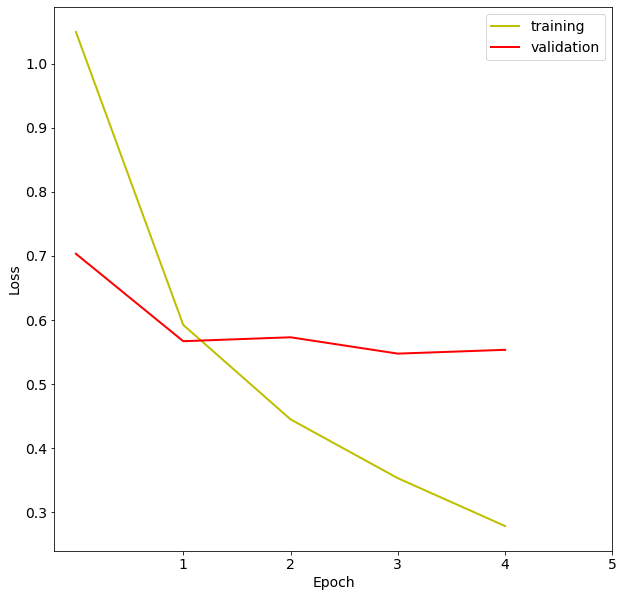

In [ ]:
plt.rcParams.update({'font.size': 14})
plt.rcParams["figure.figsize"] = [10, 10]
plt.plot(hist_train, c='y',linewidth=2.0)
plt.plot(hist_val, c='r',linewidth=2.0)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(ticks=range(1, len(hist_train)+1))
plt.legend(['training','validation'])
plt.show()

Testing

In [ ]:
def predict(predmodel, dataloader_test):

    predmodel.eval()
    predictions, true_vals, all_logits = [], [], []
    
    for batch in dataloader_test:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = predmodel(**inputs)
        
        logits = outputs[1]
        all_logits.append(logits)

        logits = logits.detach().cpu().numpy()
        true_labels = inputs['labels'].cpu().numpy()

        predictions.append(logits)
        true_vals.append(true_labels)
    
    all_logits = torch.cat(all_logits, dim=0)
    # Apply softmax to calculate probabilities
    probs = torch.nn.functional.softmax(all_logits, dim=1).cpu().numpy()

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return predictions, probs, true_vals

In [ ]:
DATASET_NAME = 'SMALL_5CLS'
model_inf = BertClassifier.from_pretrained("bert-base-uncased", num_labels=len(label_dict),
                                        output_attentions=False, output_hidden_states=False)
model_inf.to(device)
model_inf.load_state_dict(torch.load(f'/content/{DATASET_NAME}finetuned_BERT.model', map_location=torch.device('cpu')))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertClassifier: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertClassifier from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertClassifier from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertClassifier were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.b

<All keys matched successfully>

In [ ]:
MAX_TWEET_LEN = 35
BATCH_SIZE = 64

encoded_data_test = encode(test['tweet_text'].values, tokenizer, MAX_TWEET_LEN)
input_ids_test, attention_masks_test = encoded_data_test['input_ids'], encoded_data_test['attention_mask']

labels_test = torch.tensor(test['label_text'].values)

dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)

dataloader_test = DataLoader(dataset_test, 
                                   sampler=SequentialSampler(dataset_test), 
                                   batch_size=BATCH_SIZE)

predictions, probabilities, true_vals = predict(model_inf, dataloader_test)
pred_vals = [np.argmax(p) for p in probabilities]

In [ ]:
accuracy_per_class(predictions, true_vals)

print('F1 Score (weighted): ', f1_score_func(predictions, true_vals))

Class: infrastructure_and_utility_damage
Accuracy: 57/81 = 0.7037037037037037

Class: other_relevant_information
Accuracy: 165/235 = 0.7021276595744681

Class: not_humanitarian
Accuracy: 448/504 = 0.8888888888888888

Class: rescue_volunteering_or_donation_effort
Accuracy: 97/126 = 0.7698412698412699

Class: affected_individuals
Accuracy: 0/9 = 0.0

F1 Score (weighted):  0.7975773752610968


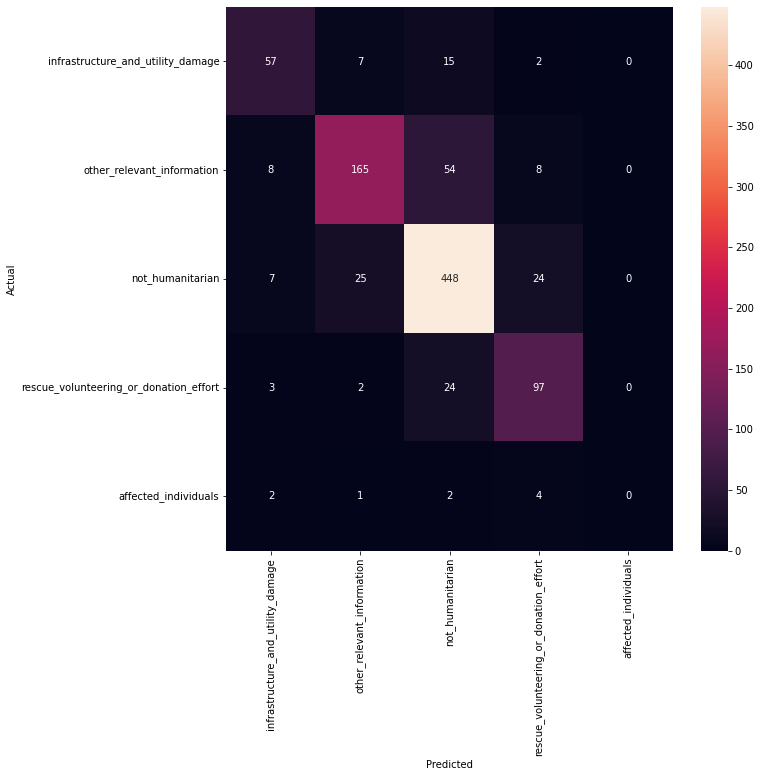

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_mat = confusion_matrix(true_vals, pred_vals)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=task_labels, yticklabels=task_labels)

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(true_vals, pred_vals, target_names=task_labels, zero_division=0))

                                        precision    recall  f1-score   support

     infrastructure_and_utility_damage       0.74      0.70      0.72        81
            other_relevant_information       0.82      0.70      0.76       235
                      not_humanitarian       0.83      0.89      0.86       504
rescue_volunteering_or_donation_effort       0.72      0.77      0.74       126
                  affected_individuals       0.00      0.00      0.00         9

                              accuracy                           0.80       955
                             macro avg       0.62      0.61      0.62       955
                          weighted avg       0.80      0.80      0.80       955



In [ ]:
# Visualize a single tweet 
MAX_TWEET_LEN = 35

sample_tweet = test['tweet_text'].values[0]
sample_label = test['label_text'].values[0]

encoded_data_sample = tokenizer.encode_plus(
  sample_tweet,
  max_length=MAX_TWEET_LEN,
  add_special_tokens=True, 
  return_attention_mask=True, 
  padding='max_length',
  truncation=True, 
  return_tensors='pt'
)

input_ids_sample = encoded_data_sample['input_ids'].to(device)
attention_masks_sample = encoded_data_sample['attention_mask'].to(device)

with torch.no_grad():        
    output = model_inf(input_ids_sample, attention_masks_sample)

logits = output.logits.detach().cpu().numpy()
pred_label = np.argmax(logits)

label_dict_inverse = {v: k for k, v in label_dict.items()}
print(sample_tweet)
print('\nActual label: ',sample_label, label_dict_inverse[sample_label], '\nPredicted label: ',pred_label, label_dict_inverse[pred_label])


 <MENTION> has a great event tomorrow for both <HASHTAG> and <HASHTAG> fans to support hurricane harvey relief <LINK>

Actual label:  3 rescue_volunteering_or_donation_effort 
Predicted label:  3 rescue_volunteering_or_donation_effort


In [ ]:
# Join probabilities to dataset

MAX_TWEET_LEN = 35

label_dict_inverse = {v: k for k, v in label_dict.items()}
test_tweets = test['tweet_text'].values
test_labels = test['label_text'].values
test_probs = []
test_preds = []

for i in range(len(test)):
  sample_tweet = test_tweets[i]
  sample_label = test_labels[i]

  encoded_data_sample = tokenizer.encode_plus(
    sample_tweet,
    max_length=MAX_TWEET_LEN,
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding='max_length',
    truncation=True, 
    return_tensors='pt'
  )

  input_ids_sample = encoded_data_sample['input_ids'].to(device)
  attention_masks_sample = encoded_data_sample['attention_mask'].to(device)

  with torch.no_grad():        
      output = model_inf(input_ids_sample, attention_masks_sample)

  logits = output.logits
  probs = torch.nn.functional.softmax(logits, dim=1).detach().cpu().numpy()[0]
  pred_label = np.argmax(probs)
  test_probs.append(probs)
  test_preds.append(label_dict_inverse[pred_label])

In [ ]:
len(test), len(test_preds), len(test_probs), len(test_probs[0])

(955, 955, 955, 5)

In [ ]:
test['pred_label_text'] = test_preds
test['pred_proba_text'] = test_probs
test['codeorder_label_text'] = [task_labels]*len(test)
test['label_text'] = test['label_text'].replace(label_dict_inverse)

In [ ]:
test.to_csv('humanitarian_SMALL_5classes_TEXTPRED.tsv', sep='\t', index=False)

In [ ]:
! zip humanitarian_SMALL_5classes_TEXTPRED.zip humanitarian_SMALL_5classes_TEXTPRED.tsv

  adding: humanitarian_SMALL_5classes_TEXTPRED.tsv (deflated 82%)


In [ ]:
# Check out some misclassified tweets
test[test.pred_label_text != test.label_text]

,event_name,tweet_id,image_id,tweet_text,image,label_text,label_image,split,pred_label_text,pred_proba_text,codeorder_label_text
7127,hurricane_harvey,907654309587779584,907654309587779584_0,after harvey irma leaves its own trail of dest...,data_image/hurricane_harvey/12_9_2017/90765430...,other_relevant_information,other_relevant_information,TEST,infrastructure_and_utility_damage,"[0.60781467, 0.18188037, 0.10388581, 0.0457744...","[infrastructure_and_utility_damage, other_rele..."
7130,hurricane_harvey,905817543503437824,905817543503437824_0,<HASHTAG> <HASHTAG> transposed over <HASHTAG> ...,data_image/hurricane_harvey/7_9_2017/905817543...,other_relevant_information,other_relevant_information,TEST,not_humanitarian,"[0.02314107, 0.27044448, 0.68080425, 0.0139075...","[infrastructure_and_utility_damage, other_rele..."
7144,hurricane_irma,909688082911203328,909688082911203328_0,first harvey then irma and jose why it s the s...,data_image/hurricane_irma/18_9_2017/9096880829...,not_humanitarian,not_humanitarian,TEST,other_relevant_information,"[0.029478503, 0.5397135, 0.39742213, 0.0140363...","[infrastructure_and_utility_damage, other_rele..."
7145,mexico_earthquake,910566671148085251,910566671148085251_0,<MENTION> video shows dog being pulled to safe...,data_image/mexico_earthquake/20_9_2017/9105666...,rescue_volunteering_or_donation_effort,rescue_volunteering_or_donation_effort,TEST,not_humanitarian,"[0.03715216, 0.0994012, 0.6079134, 0.23037289,...","[infrastructure_and_utility_damage, other_rele..."
7146,hurricane_maria,914096124776058880,914096124776058880_0,<MENTION> and <MENTION> ahead of <HASHTAG> and...,data_image/hurricane_maria/30_9_2017/914096124...,not_humanitarian,not_humanitarian,TEST,other_relevant_information,"[0.030794404, 0.53314453, 0.40950224, 0.012567...","[infrastructure_and_utility_damage, other_rele..."
...,...,...,...,...,...,...,...,...,...,...,...
8059,hurricane_maria,922107994741137410,922107994741137410_0,<MENTION> <MENTION> how about getting some pow...,data_image/hurricane_maria/22_10_2017/92210799...,other_relevant_information,other_relevant_information,TEST,not_humanitarian,"[0.009837816, 0.017388025, 0.95746857, 0.01061...","[infrastructure_and_utility_damage, other_rele..."
8069,hurricane_maria,916139171663765504,916139171663765504_0,<MENTION> champions for puerto rico medical re...,data_image/hurricane_maria/6_10_2017/916139171...,not_humanitarian,not_humanitarian,TEST,rescue_volunteering_or_donation_effort,"[0.010590567, 0.024552971, 0.34087732, 0.60269...","[infrastructure_and_utility_damage, other_rele..."
8074,iraq_iran_earthquake,930415579294584834,930415579294584834_0,iran survivors struggle in aftermath of years ...,data_image/iraq_iran_earthquake/14_11_2017/930...,affected_individuals,affected_individuals,TEST,rescue_volunteering_or_donation_effort,"[0.03092342, 0.050138276, 0.1879188, 0.6925108...","[infrastructure_and_utility_damage, other_rele..."
8076,mexico_earthquake,910670262789709824,910670262789709824_0,s a f e b o y e s ready to look for people aft...,data_image/mexico_earthquake/21_9_2017/9106702...,rescue_volunteering_or_donation_effort,rescue_volunteering_or_donation_effort,TEST,not_humanitarian,"[0.0065432196, 0.031845696, 0.8828842, 0.07066...","[infrastructure_and_utility_damage, other_rele..."
